In [1]:
## HW02 Code

### Name: Myette F Simpson

#You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
#1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
#2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


#Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2021/comp135/home).

# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [2]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [3]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [4]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [5]:
from sklearn.model_selection import train_test_split
import operator

def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    for i in range(len(polynomials)):
        
        degree = polynomials[i]
        poly = PolynomialFeatures(degree)
        xpoly = poly.fit_transform(x)

        linearRegression2 = linear_model.LinearRegression()
        linearRegression2.fit(xpoly, y)
        
        yPredict = linearRegression2.predict(xpoly)
        
        prediction_list.append(yPredict)

        # overall squared error on training, normalized to maximum salary (y-value)
        error_list.append(mean_squared_error(y, yPredict))
    
    return prediction_list, error_list
    

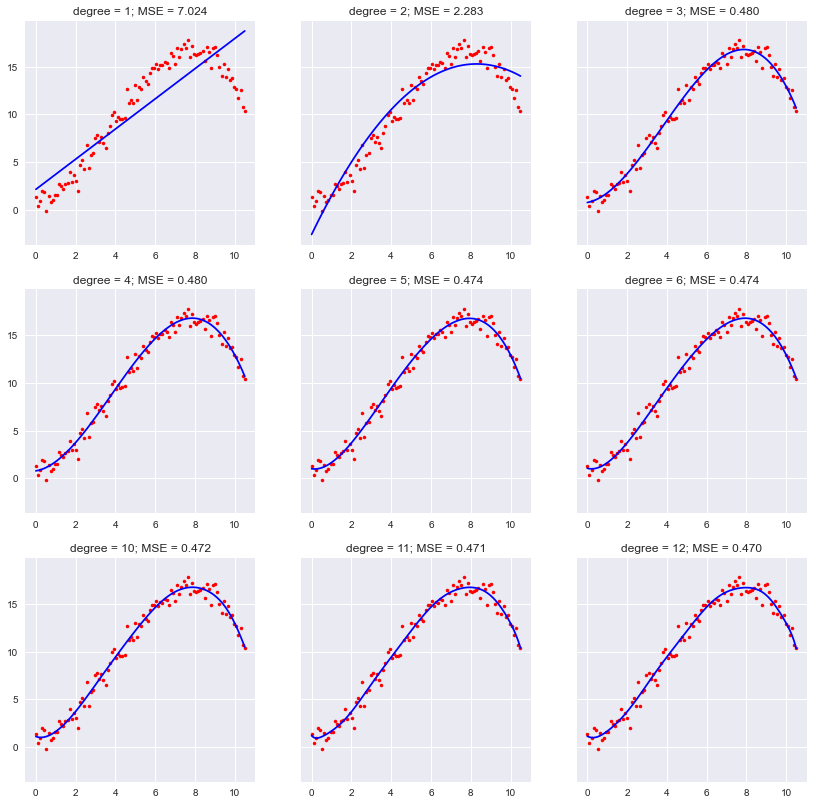

In [6]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results

d = [1,2,3,4,5,6,10,11,12]

pred_lst, error_lst = test_polynomials(d)

plot_predictions(d, pred_lst, error_lst)



#### 1.2 Discuss the results seen in the plots above

**Discussion**:  The results show that as we increase the degree of our polynomial we are getting getting a slightly better MSE. The first and second degree models do much worse for this model than higher degree models. A larger MSE means a higer variance in our model. The lowest MSE is at the 12th degree. This tells me that if we use a 12th degree polynomial I'll have the most accurate predections for my model based on the current data that I have. However the gains after a degree = 3 are marginal, and as our degree increases we run the risk of overfitting or interpretability so degree = 3 would be the ideal model. If we were to go strictly on the lowest MSE, the 12 degree model would be the best model.

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [7]:
def make_folds(num_folds):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    # TODO: Complete method to generate partition into folds.
    kfold = num_folds
    k = 1
    
    #loop thorugh until each fold is created
    while (k <= kfold):
        # find start and end to each fold
        k_len = len(y)
        fold = (k)/kfold
        end = int((k_len*fold))
        start = int((end - 1/kfold*k_len))
        
        #index x data
        xfold = x[start:end]
        x_folds.append(xfold)
        
        #index y data
        yfold = y[start:end]
        y_folds.append(yfold)
        
        #update count
        k = k+1
    return x_folds, y_folds

In [8]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.  Its output will be used to check your work.
k = 5
x_folds, y_folds = make_folds(k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

In [9]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.

# should be 15 degree

In [10]:
#input: testing and training data in the form of lists, the degree of polynomial in form of an int
#output: two lists of average mean square error for each fold
def train_test_split(xTrain, yTrain, xTest, yTest, d):
    from sklearn.preprocessing import PolynomialFeatures

    poly = PolynomialFeatures(degree = d)
    xTrain_poly = poly.fit_transform(xTrain)
    xTest_poly = poly.fit_transform(xTest)
    
    #build regression model
    linearRegressionModel = linear_model.LinearRegression()
    linearRegressionModel.fit(xTrain_poly, yTrain)

    #predictions the model makes on input sets;
    yTestPredict = linearRegressionModel.predict(xTest_poly)
    yTrainPredict = linearRegressionModel.predict(xTrain_poly)
    
    #find mean square error
    mse_k_test = mean_squared_error(yTest, yTestPredict)
    mse_k_train = mean_squared_error(yTrain, yTrainPredict)
    
    return mse_k_test, mse_k_train
    
KF = 5
testlist = list(range(KF))
d = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
averagesTest = []
averagesTrain = []

for degree in range(len(d)):
    poly = d[degree]
    mseFoldTest = []
    mseFoldTrain = []
    
    #perform cross validation on every degree
    for i in testlist:
        
        Xtest = x_folds[i]
        Ytest = y_folds[i]

        Xtrain = x_folds[i+1:] + x_folds[:i]
        npXtrain = np.array(Xtrain)
        Xtrain_reshape = npXtrain.flatten().reshape(-1,1)
        XtrainUpdate = list(Xtrain_reshape)
       
        Ytrain = y_folds[i+1:] + y_folds[:i]
        npYtrain = np.array(Ytrain)
        Ytrain_reshape = npYtrain.flatten().reshape(-1,1)
        
        mseCurrentKFold_Test, mseCurrentKFold_Train = train_test_split(Xtrain_reshape, Ytrain_reshape, Xtest, Ytest, poly)
        mseFoldTest.append(mseCurrentKFold_Test)
        mseFoldTrain.append(mseCurrentKFold_Train)
        
    #print(mesFold)
    degreeMseAvTest = sum(mseFoldTest)/len(mseFoldTest)
    degreeMseAvTrain = sum(mseFoldTrain)/len(mseFoldTrain)
    averagesTest.append(degreeMseAvTest)
    averagesTrain.append(degreeMseAvTrain) 

df = pd.DataFrame({'degree' : d, 'mse_Test' : averagesTest, 'mse_Train' : averagesTrain })  
df.set_index('degree', inplace=True)
df
    

,mse_Test,mse_Train
degree,,
1,7.441157,6.977641
2,2.625608,2.245920
3,0.558083,0.471621
4,0.574623,0.469909
5,0.574580,0.463663
6,0.586606,0.462069
7,0.584519,0.461471
8,0.594491,0.460314
9,0.600986,0.459665


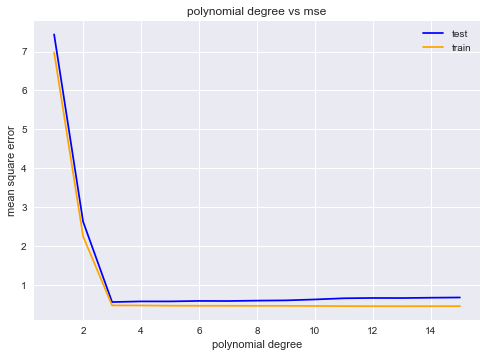

In [11]:
#plt.scatter(xTrain, yTrain, color='red')
plt.plot(d, averagesTest, label = 'test',color='blue')
plt.plot(d, averagesTrain, label = 'train', color='orange')
plt.title('polynomial degree vs mse')
plt.xlabel('polynomial degree')
plt.ylabel('mean square error')
plt.legend()
plt.show()

#### 2.3 Discuss the results seen in the plots above

**Discussion:** From 1-3 we are reducing overall error and neither error (Train and test) is minimized. At poly degree 3 we reach model of best complexity. After 3 our testing error begins to increase and diverges from our training error, meaning our true error is no longer minimized (cross validation allows us to review the true error). Based on this and the increase in model complixity, we can conculude our best model is at d=3.

### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

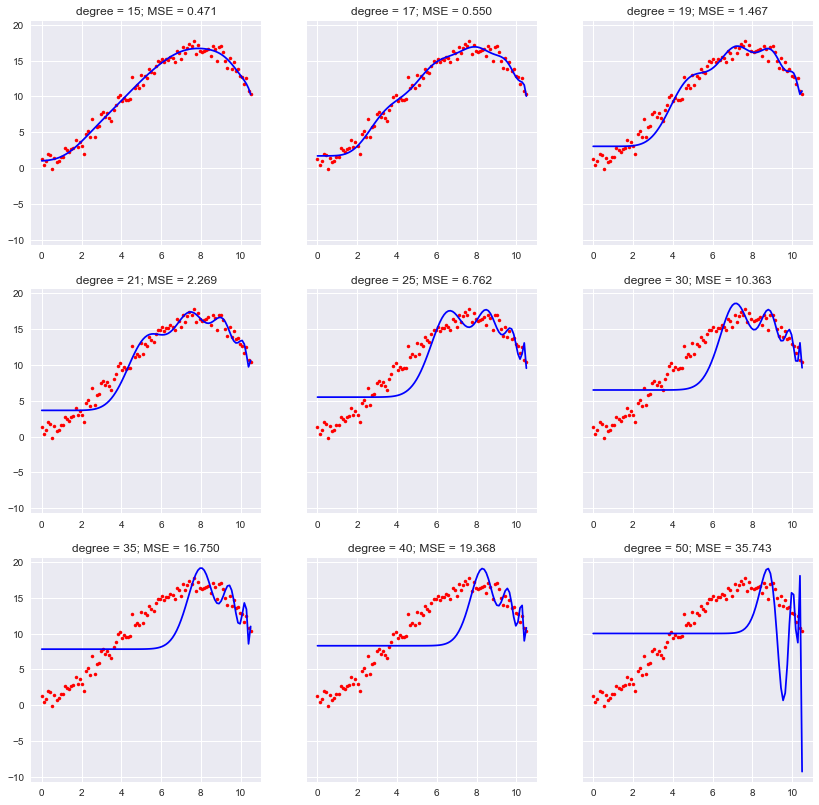

In [12]:
# TODO: generate and plot 9 more models, for the higher-degree polynomials indicated.

d = [15,17,19,21,25,30,35,40,50]

pred_lst, error_lst = test_polynomials(d)

plot_predictions(d, pred_lst, error_lst)

#### 3.2 Discuss the results seen in the plots above

**Discussion**: The results show that the model is overfit. Although it does not show us the overfit model in the way you would expect. Overfitting refers to the model being so precise on training data we loose accuracy on new data coming into the model. Generally you'd expect your blue line (the model) to touch or go through more of the red data points as we increase our degree, however the designers of SKlearn have ommitted this to increase efficency of the model. Once a model is extremly overfit it will give you a polynomial like the ones above by scikitlearn design.

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

In [13]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.

In [14]:
from sklearn.linear_model import Ridge

#input: testing and training data in the form of lists, the degree of polynomial in form of an int, alpha in the form of a float
#output: two lists of average mean square error for each fold
def Ridge_model(xTrain, yTrain, xTest, yTest, d, a):
    from sklearn.preprocessing import PolynomialFeatures

    poly = PolynomialFeatures(degree = d)
    xTrain_poly = poly.fit_transform(xTrain)
    xTest_poly = poly.fit_transform(xTest)
    
    #istantiate the model, fit the model through the data
    ridgeModel = Ridge(alpha = a)
    ridgeModel.fit(xTrain_poly, yTrain)

    #predictions the model makes on input sets;
    yTestPredict = ridgeModel.predict(xTest_poly)
    yTrainPredict = ridgeModel.predict(xTrain_poly)
    
    #find mean square error
    mse_k_test = mean_squared_error(yTest, yTestPredict)
    mse_k_train = mean_squared_error(yTrain, yTrainPredict)
    
    return mse_k_test, mse_k_train

In [15]:
KF = 5
testlist = list(range(KF))
d = 3
a = np.logspace(-2, 2, base=10, num=50)
averagesRTest = []
averagesRTrain = []

#find average MSE for each alpha in a
for alpha in range(len(a)):
    alphaInput = a[alpha]
    mseRFoldTest = []
    mseRFoldTrain = []
    
    #perform Ridge Regression on every fold
    for i in testlist:
        #identifies test data
        XRtest = x_folds[i]
        YRtest = y_folds[i]
        
        #identifies and formats X training data
        XRtrain = x_folds[i+1:] + x_folds[:i]
        npXRtrain = np.array(XRtrain)
        XRtrain_reshape = npXRtrain.flatten().reshape(-1,1)
        XRtrainUpdate = list(XRtrain_reshape)
        
        #identifies and formats Y training data
        YRtrain = y_folds[i+1:] + y_folds[:i]
        npYRtrain = np.array(YRtrain)
        YRtrain_reshape = npYRtrain.flatten().reshape(-1,1)
        
        #finds the MSE for every fold in model, then adds to a list
        mseRCurrentKFold_Test, mseRCurrentKFold_Train = Ridge_model(XRtrain_reshape, YRtrain_reshape, XRtest, YRtest, d, alphaInput)
        mseRFoldTest.append(mseRCurrentKFold_Test)
        mseRFoldTrain.append(mseRCurrentKFold_Train)
    
    #takes average of every fold in the list
    alphaMseAvTest = sum(mseRFoldTest)/len(mseRFoldTest)
    alphaMseAvTrain = sum(mseRFoldTrain)/len(mseRFoldTrain)
    averagesRTest.append(alphaMseAvTest)
    averagesRTrain.append(alphaMseAvTrain)
    
df2 = pd.DataFrame({'alpha' : a, 'mse_RTest' : averagesRTest, 'mse_RTrain' : averagesRTrain })  
df2

,alpha,mse_RTest,mse_RTrain
0,0.010000,0.558036,0.471621
1,0.012068,0.558026,0.471621
2,0.014563,0.558015,0.471621
3,0.017575,0.558001,0.471621
4,0.021210,0.557984,0.471621
5,0.025595,0.557963,0.471621
6,0.030888,0.557939,0.471621
7,0.037276,0.557909,0.471621
8,0.044984,0.557873,0.471621
9,0.054287,0.557831,0.471621


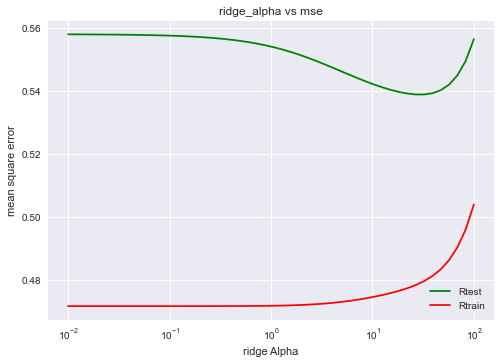

In [16]:
#plt.scatter(xTrain, yTrain, color='red')
plt.xscale('log')
plt.plot(a, averagesRTest, label = 'Rtest',color='green')
plt.plot(a, averagesRTrain, label = 'Rtrain', color='red')
plt.title('ridge_alpha vs mse')
plt.xlabel('ridge Alpha')
plt.ylabel('mean square error')
plt.legend()
plt.show()

#### 4.2 Discuss the results seen in the plots above

**Discussion**:  The results show that our most effective alpha for our problem is around 40. The minimuam in our testing MSE inditcat eht cross section between our suqred bias and our variance these two attributes are inversly correlated with Ridge models, so finding the crosssection allows us to find the best model without compromise of either. 